In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('parkinsons.data')

# Display basic information
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)

# Calculate correlation matrix using numeric_only parameter
correlation_matrix = df.corr(numeric_only=True)


Dataset shape: (195, 24)

Column names: ['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']

Data types:
 name                 object
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
status                int64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
P

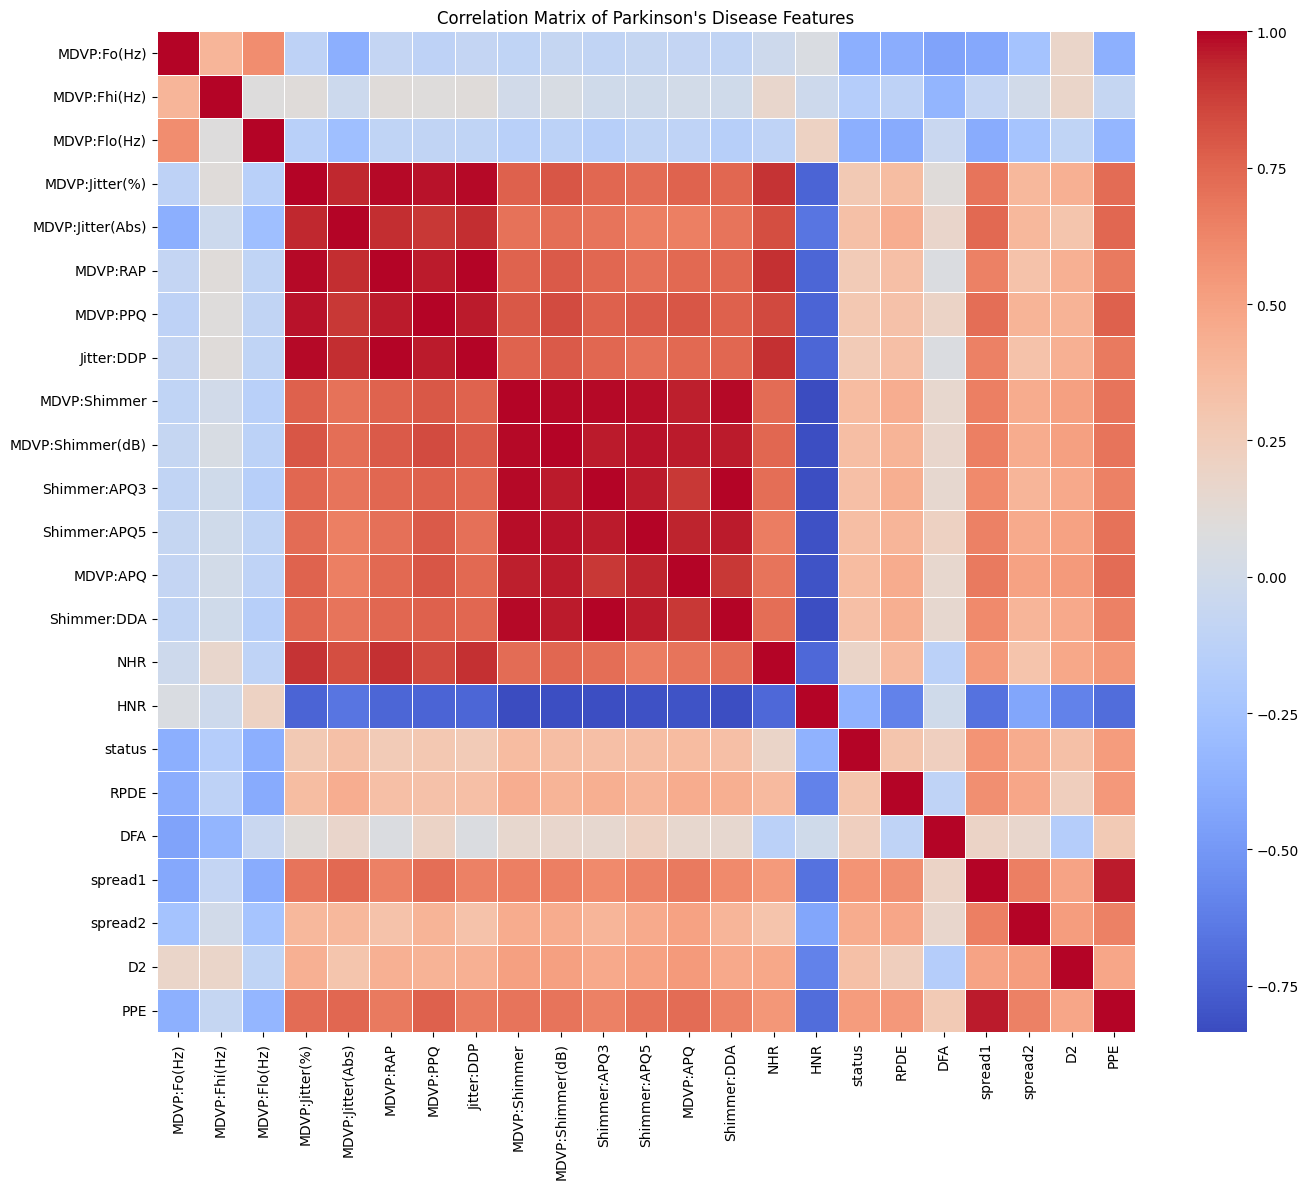

In [4]:

# Visualize the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Parkinson\'s Disease Features')
plt.tight_layout()
plt.show()

In [5]:
# Find correlations with the target variable (status)
target_correlations = correlation_matrix['status'].sort_values(ascending=False)
print("\nFeatures correlated with Parkinson's disease (status):")
print(target_correlations)


Features correlated with Parkinson's disease (status):
status              1.000000
spread1             0.564838
PPE                 0.531039
spread2             0.454842
MDVP:Shimmer        0.367430
MDVP:APQ            0.364316
Shimmer:APQ5        0.351148
MDVP:Shimmer(dB)    0.350697
Shimmer:APQ3        0.347617
Shimmer:DDA         0.347608
D2                  0.340232
MDVP:Jitter(Abs)    0.338653
RPDE                0.308567
MDVP:PPQ            0.288698
MDVP:Jitter(%)      0.278220
MDVP:RAP            0.266668
Jitter:DDP          0.266646
DFA                 0.231739
NHR                 0.189429
MDVP:Fhi(Hz)       -0.166136
HNR                -0.361515
MDVP:Flo(Hz)       -0.380200
MDVP:Fo(Hz)        -0.383535
Name: status, dtype: float64


In [7]:
# Extract features and target
# The 'name' column contains patient identifiers which are not useful for prediction
features = df.drop(['name', 'status'], axis=1)
target = df['status']

# Get feature names for later use
feature_names = features.columns

# Check for class imbalance
print("\nTarget Variable Distribution:")
print(target.value_counts())
print(f"Percentage of Parkinson's cases: {target.mean()*100:.2f}%")

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Convert scaled features back to DataFrame for better handling
scaled_features_df = pd.DataFrame(scaled_features, columns=feature_names)

# Feature selection using SelectKBest
selector = SelectKBest(f_classif, k=15)  # Select top 15 features
X_selected = selector.fit_transform(scaled_features, target)

# Get names of the selected features
selected_indices = selector.get_support(indices=True)
selected_features = feature_names[selected_indices]
print("\nSelected Features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

# Create a DataFrame with only selected features
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, target, test_size=0.2, random_state=42, stratify=target
)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass distribution before SMOTE:")
print(pd.Series(y_train).value_counts())
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())



Target Variable Distribution:
status
1    147
0     48
Name: count, dtype: int64
Percentage of Parkinson's cases: 75.38%

Selected Features:
1. MDVP:Fo(Hz)
2. MDVP:Flo(Hz)
3. MDVP:Jitter(Abs)
4. MDVP:Shimmer
5. MDVP:Shimmer(dB)
6. Shimmer:APQ3
7. Shimmer:APQ5
8. MDVP:APQ
9. Shimmer:DDA
10. HNR
11. RPDE
12. spread1
13. spread2
14. D2
15. PPE

Class distribution before SMOTE:
status
1    118
0     38
Name: count, dtype: int64

Class distribution after SMOTE:
status
0    118
1    118
Name: count, dtype: int64



Random Forest Model Evaluation:
Accuracy: 0.8974
ROC AUC Score: 0.9517

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        29

    accuracy                           0.90        39
   macro avg       0.87      0.87      0.87        39
weighted avg       0.90      0.90      0.90        39



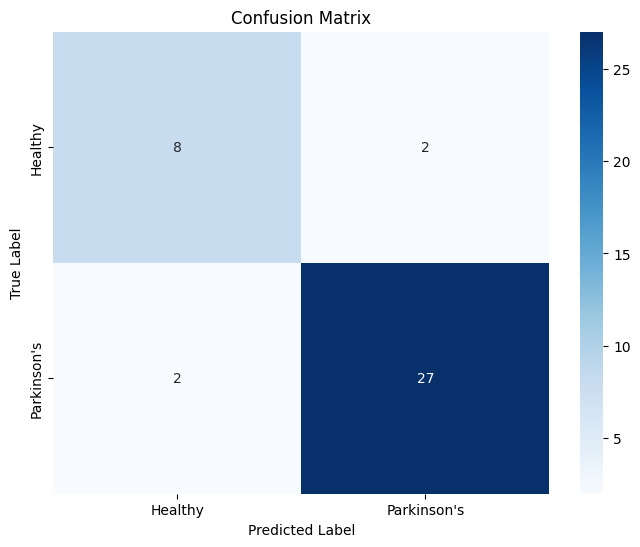

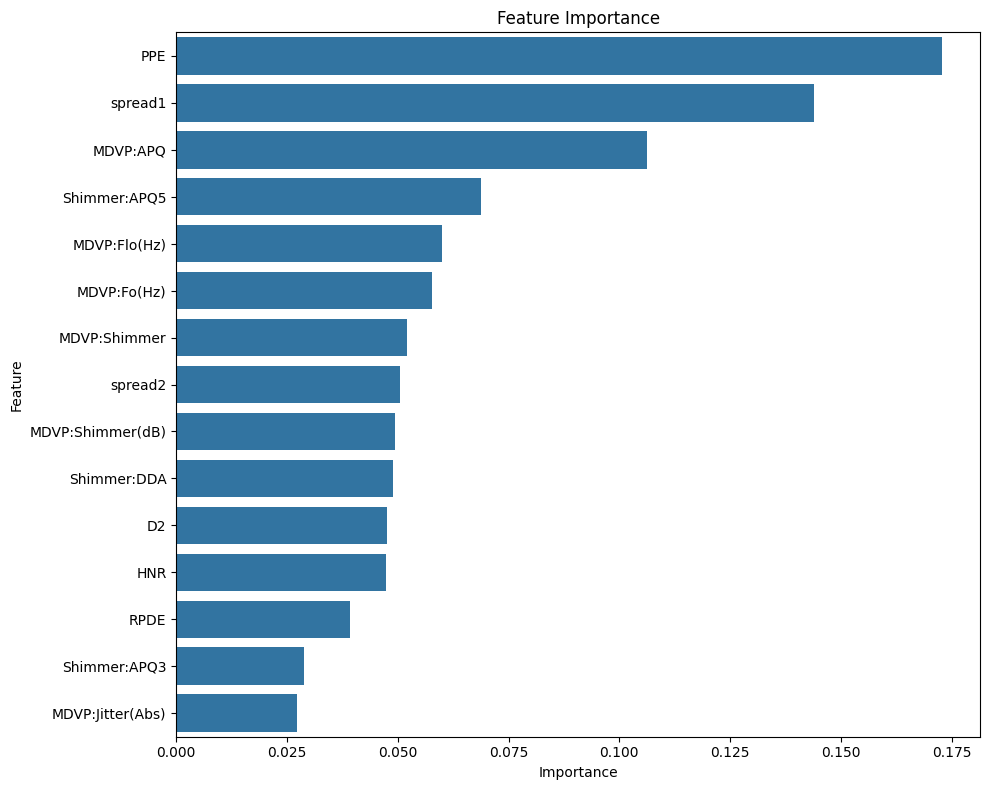

In [8]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

# Fit the model on the resampled training data
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'Parkinson\'s'],
            yticklabels=['Healthy', 'Parkinson\'s'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [9]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)

# Print best parameters
print("\nBest Parameters:", grid_search.best_params_)

# Evaluate the model with best parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\nBest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_best):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))



Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

Best Model Evaluation:
Accuracy: 0.8974
ROC AUC Score: 0.9621

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        29

    accuracy                           0.90        39
   macro avg       0.87      0.87      0.87        39
weighted avg       0.90      0.90      0.90        39

